# CEG5304/EE6934 Deep Learning Project 2

In this project, you are going to start an exciting journey to explore Deep Learning and Neural Networks by completing the following three tasks:

* Task 1. Building Neural Network (30%)
* Task 2. Exploring Model Training (30%)
* Task 3. Adversarial Attack (40%)

Before doing the project, please read the instructions carefully (failure to do so will be penalized):

1. Implement your codes **within** "TODO" and "END OF YOUR CODE", do **NOT** modify any codes outside the answer area;
2. Make sure your codes **clean**, **easily readable** (add meaningful comments if needed), and **runnable**;
3. Write your answers in the given markdown cells, keep your answers clear and concise;
4. Do submit your project to "Assignments --> Project 2" on [Canvas](https://canvas.nus.edu.sg/) before the deadline: **5:59 pm (SGT), 6 March, 2023**;
5. This is an individual project, do **NOT** share your solutions with others, we have zero tolerance for cheating.

If you have any questions regarding this project, please feel free to contact Zhangjie Wu (zhangjiewu@u.nus.edu) and Liu, Jiawei (jiawei.liu@u.nus.edu). 

## Preparation

### Loading packages

Please install the packages listed below if you haven't done so. To avoid unnecessary trouble reproducing your assignment, we recommend you to use `torch==1.9.0` and `torchvision==0.10.0`.

In [1]:
# !pip install torch==1.9.0
# !pip install torchvision==0.10.0

In [78]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as mpl_color_map
from PIL import Image
from random import randint

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

### Checking the Running Device

It is recommended to run this notebook on GPUs since that would be a much faster way to train and evaluate the model. If you have difficulties accessing GPUs with your machine, you can choose to use the free GPUs provided by [Google Colab](https://colab.research.google.com/).

In [79]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'
print(device)

cpu


### Getting the CIFAR-10 Dataset

In [4]:
CIFAR_CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
CIFAR_MEAN, CIFAR_STD = np.array([0.4914, 0.4822, 0.4465]), np.array([0.247, 0.243, 0.261])

# Convert image to pytroch tensor and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
])

# Inverse operation to regain original image
inverse_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=[0, 0, 0], std=(1 / CIFAR_STD).tolist()),
    torchvision.transforms.Normalize(mean=(-CIFAR_MEAN).tolist(), std=[1, 1, 1]),
    torchvision.transforms.ToPILImage()
])

# Load dataset
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


### Helper Fuctions

In [5]:
def show_prob_cifar(image, label, p):
    """
        Show image and prediction probability for CIFAR-10 dataset.
    Args:
    Inputs
        image (Tensor): Input image
        label (int): The ground truth label of input image
        p (Tensor): Class probability of input image
    
    """

    ft = 10
    width = 0.9
    col = 'blue'

    p=p.cpu().data.squeeze().numpy()
    y_pos = np.arange(len(p))
    fig = plt.figure(figsize=(5, 5))

    # Plot image
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.set_axis_off()
    ax1.set_title('Ground Truth: ' + CIFAR_CLASSES[label])

    # Plot probability
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(y_pos, p*0.1, width , align='center', color=col)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(CIFAR_CLASSES, fontsize=ft)
    ax2.invert_yaxis()  
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_linewidth(4)
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax2.text(p[i]*0.1 + 0.001, y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax2.transData, color= col,fontsize=ft)

    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

## Task 1: Building Neural Network

In this task, you are expected to build a convolutional neural network (CNN) for solving a problem of image recognition and explore strategies that could further strengthen its performance.  

### Defining the Model

In deep learning, a Convolutional Neural Network (CNN, or ConvNet) is one of the most famous deep learning models that have been widely used in the field of computer vision. A simple CNN often consists of three main types of layers:
- **Convolutional Layer**, the core building block that takes over the most of computational burdens, contains a set of filters (or kernels) with learnable parameters while training. It receives as input an image (or a feature map), and computes its output volume by stacking the activation maps convolved by every filter along the depth dimension. 
- **Pooling Layer** is commonly inserted in-between successive Conv layers in a CNN architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- **Fully Connected Layer** have fully connections to all activations in the previous layer and is usually placed before the output layer to form the last few layers of a CNN Architecture.

If you are not familiar with CNN architectures, [this blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) may help you get a better understanding of the mechanism of each layer.

Define a naive CNN stacked by the layers mentioned above. While doing so, please follow the TODOs provided below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [6]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() 
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        
        # Block 1:         3 x 32 x 32 --> 32 x 16 x 16     
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 32+2-3 +1 = 32, 32 x 32 x32
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 32 x 16 x 16  
        
        # Block 2:         32 x 16 x 16 --> 64 x 8 x 8
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #16+2-3 +1 = 16, 64 x 16 x 16
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # 64 x 8 x 8
        
        # Block 3:         64 x 8 x 8 --> 128 x 4 x 4       
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 8+2-3 + 1 = 8, 128 x 8 x 8
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 4:          128 x 4 x 4 --> 256 x 2 x 2
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # 4+2-3 +1 = 4, 256 x 4 x 4
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layers:   256 x 2 x 2 --> 1024 --> 2048 --> 4096 --> 4096 --> 10
        self.fc1 = torch.nn.Linear(in_features=256*2*2, out_features=1024)
        self.fc2 = torch.nn.Linear(in_features=1024, out_features=2048)
        self.fc3 = torch.nn.Linear(in_features=2048, out_features=4096) 
        self.fc4 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.fc5 = torch.nn.Linear(in_features=4096, out_features=10)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         3 x 32 x 32 --> 32 x 16 x 16
        x = self.pool1(F.relu(self.conv1(x)))

        # Block 2:         32 x 16 x 16 --> 64 x 8 x 8
        x = self.pool2(F.relu(self.conv2(x)))

        # Block 3:         64 x 8 x 8 --> 128 x 4 x 4
        x = self.pool3(F.relu(self.conv3(x)))

        # Block 4:         128 x 4 x 4 --> 256 x 2 x 2
        x = self.pool4(F.relu(self.conv4(x)))

        # Linear layers:   256 x 2 x 2 --> 1024 --> 2048 --> 4096 --> 4096 --> 10  
        x = x.view(-1, 256*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=4096, bias=True)
  (fc5): Linear(in_features=4096, out_features=10, bias=True)
)


### Training the Model

Some default settings for training. 

In [7]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.25

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Here, your job is to implement two functions for training and testing model.

In [8]:
def eval_on_test_set(model):
    model.eval()
    running_error = 0

    for data in test_loader:
        pass
        ##############################################################################
        # TODO: Implement the evaluation process on test set.                        #
        ##############################################################################
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # Load inputs and labels and deploy to running device
        outputs = model(images)
        # Forward batch data through the net
        _, predicted = torch.max(outputs, 1)
        error = (predicted != labels).sum().item()
        print("Error:", error)
        running_error += error
        # Compute the error made on this batch and add it to the running error

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    model.train()


In [9]:
def train_net(model):
    start=time.time()
    model.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in train_loader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # Load inputs and labels and deploy to running device
            optimizer.zero_grad()
            # Set the gradients to zeros
            outputs = model(images)
            # Forward the batch data through the net       
            loss = criterion(outputs, labels)
            print("Cross-Entropy Loss:", loss)
            mean_loss = loss.mean()
            print("Cross-Entropy Mean Loss:", mean_loss)
            # Compute the average of the losses of the data points in the minibatch
            loss.backward()
            # Backward pass to compute gradients
            optimizer.step()
            # Do one step of stochastic gradient descent
            running_loss += loss
            # Add the loss of this batch to the running loss
            _, predicted = torch.max(outputs, 1)
            error = (predicted != labels).sum().item()
            running_error += error
            # Compute the error made on this batch and add it to the running error
            
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model) 

Run `train_net` and start training. After training, your error on the testing set should be under 30% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

In [10]:
# Start training
#train_net(model)
# Save the trained model
#torch.save(model.state_dict(), './model_cnn.pt')

### Ploting the Results

Now you have finished model training, let's randomly pick some test images, feed them into your model and see how they turn out. (There is nothing to implement in this section.)

In [11]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=4096, bias=True)
  (fc5): Linear(in_features=4096, out_features=10, bias=True)
)

3667


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


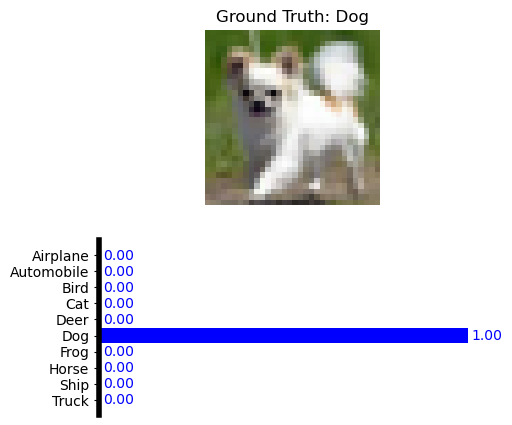

In [12]:
# Choose a picture at random
idx = randint(0, test_size-1)
print(idx)
im, label = test_set[idx]
org_im = inverse_transform(im)

# Send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = im.view(1,3,32,32)

# Feed it to the net and display the confidence scores
scores = model(im)
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

### Refining the Model

Although the vallina model has achieved fair classification results, the test error is still high remaining huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., making your network deeper), **optimizing the learning strategy** (e.g., optimizer, loss function), and **tuning the hyperparameters** (e.g., learning rate, training iterations), etc. Please try at least **TWO** different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively). 

In [13]:

##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################
#error rate on test set = 25.87% final result from final epoch run
# optimizing learning strategy:
# epochs = 30
# batch_size = 64
# learning_rate = 0.20
# modelMOM = ConvNet()
# modelMOM.to(device)
# # Set up optimizer
# optimizer = optim.Adadelta(modelMOM.parameters(), lr=learning_rate)
# # Define loss function
# criterion = torch.nn.CrossEntropyLoss()
# train_net(modelMOM)

class ConvNetTest(torch.nn.Module):
    def __init__(self):
        super(ConvNetTest, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(inplace=True),
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 512, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 2048, kernel_size=1, stride=1, bias=False),
            torch.nn.BatchNorm2d(2048),
            torch.nn.ReLU(inplace=True),
        )
        #self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(2048*2*2, 10)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.bn1(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.maxpool(x)
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        x = self.layer4(x)
        #print(x.shape)
        x = x.view(-1, 2048*2*2)
        #x = self.avgpool(x)
        x = self.fc(x)
        
        return x

epochs = 40
batch_size = 128
learning_rate = 0.001
modelAdam = ConvNetTest()
modelAdam.to(device)
optimizer = optim.Adam(modelAdam.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
train_net(modelAdam)
# modelAda = ConvNet()
# modelAda.to(device)
# optimizer = optim.Adagrad(modelAda.parameters(), lr=learning_rate)
# train_net(modelAda)
# your code

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

---

## Task 2: Exploring Model Training

The model is doing well, eating images and predicting results; however, everything that happens inside is opaque and hard to explain. So, how can we interpret how CNN sees and understands when making a decision? 

In this section, we are going to explore Grad-CAM, a visual explanation algorithm that generates heatmaps indicating where the network is "looking" in the forward pass.

### Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) [1], uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. An overview of the workflow of Grad-CAM is shown below. Please read the paper [1], understand the algorithm, and implement `generate_cam`.

[1] [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." ICCV 2017.](https://arxiv.org/abs/1610.02391)

In [14]:
gradients = []  # A gloabl variable used to save the gradient
def generate_cam(model, input_image, target_layer='conv4', target_class=None):
    """
    A function to generate Grad-CAM of specific layer and class on an input image using given model.
    Inputs
    - model: A PyTorch model.
    - input_image: A PyTorch Tensor of shape (1, C, H, W).
    - target_layer: A String indicating the name of targeted convolutional layer being visualized (e.g., 'conv4').
                    By default, use the last conv layer of the model.
    - target_class: An Integer indicating the lable of targeted class being visualized (e.g., 1). 
                    If None, use the predicted class as target class.
    
    Returns: A NumPy Array of shape (N, C, H, W) showing the intended heatmap.
    """

    ##############################################################################
    # TODO: Given an input image, generate its Grad-CAM on target conv layer     #
    # using the backward gradients from a specific class.                        #
    # 1. Forward the input image, when you also need to register the gradient    #
    # hook so as to get the gradient in backward pass (hint: register_hook).     #
    # 2. Backward pass with specified target class, and get gradients.           #
    # 3. Average each gradient, multiply with its conv output, and sum together. #
    ##############################################################################
    # target_layer_object = None
    global gradients
    gradients.clear
    target_layer_ = getattr(model, target_layer)
    
    if target_layer_ is None:
        print("No target layer found: Find ourselves ", model.children)
        target_layer_ = [module[0] for module in model.named_modules() if isinstance(module[1], torch.nn.Conv2d)][-1]
    
    model.eval()    
    target_output_fwd = None
    target_output_back = None
    
    # hooks = []
    # for name, module in model.named_modules():
    #     if name == target_layer:
    #         def fwd_hook(module, input, output):
    #             nonlocal target_output_fwd
    #             target_output_fwd = output.detach()
    #         def back_hook(module, input, output):
    #             nonlocal target_output_back
    #             module.back_grad = output[0]
    #         hooks.append(module.register_forward_hook(fwd_hook))
    #         hooks.append(module.register_backward_hook(back_hook))
    def forward_hook(module, input, output):
        global gradients
        module.output = output
        gradients.append(output)
        
    hook_handle = target_layer_.register_forward_hook(forward_hook)
    
    input_image.requires_grad_()
    model.zero_grad()
    feature_maps = model(input_image)
    #print("feature map size ", feature_maps.shape)
    if target_class is None:
            # Use the predicted class as target class
            target_class = feature_maps.argmax(dim=1)
            print("No target class found Using pred: ", target_class)
    
    one_hot = torch.zeros((1, feature_maps.size()[-1]), dtype=torch.float)
    one_hot[0][target_class] = 1
    one_hot_grad = torch.autograd.Variable(one_hot, requires_grad=True)
    
    feature_maps.backward(gradient=one_hot_grad, retain_graph=True)
    
    res = []
    while(None in gradients):
        gradients.remove(None)
    #print("gradients: ", [g.shape for g in gradients])
    gradients2 = gradients[0].data.numpy()[0]
    #print(gradients2.shape)
    features = target_layer_.output.cpu().data.numpy()[0]
    #print(gradients2.shape)
    #print(features.shape)
    weights = np.mean(gradients2, axis=(1, 2))
    #print(weights.shape)
    cam = np.zeros(features.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * features[i, :, :]
    
    hook_handle.remove()
    gradients.clear()
    # with torch.enable_grad():
    #     input_image.requires_grad = True
    #     input_image.register_hook(lambda grad: gradients.append(grad))
    #     feature_maps = model(input_image)
    #     #feature_maps.requires_grad = True
    #     print(feature_maps.shape)
    #     print(gradients)
    #     if target_class is None:
    #         # Use the predicted class as target class
    #         target_class = feature_maps.argmax(dim=1)
    #         print("No target class found Using pred: ", target_class)
    # with torch.enable_grad():
    #     model.zero_grad()
    #     print(feature_maps)
    #     print(feature_maps[:, target_class])
    #     output = feature_maps[:, target_class]
    #     #output.retain_grad()
    #     #output.register_hook(lambda grad: gradients.append(grad))
    #     output.backward()
    #     #gradients = target_output.grad
    #     print("gradients: " + str(gradients[0].shape))
    #     print("fwd: ", target_output_fwd)
    #     print("back: ",target_output_back)
    
    # for hook in hooks:
    #     hook.remove()
    
    # weights = np.mean(gradients[0].numpy())
    # cam = np.sum(weights * feature_maps.detach().numpy(), axis=0)  
    
    #average each gradient
    # weights = F.adaptive_avg_pool2d(gradient, 1)
    # #Multiply with conv output:feature maps
    # cam = torch.matmul(weights, feature_maps.reshape(feature_maps.shape[1], -1))
    # cam = cam.reshape(feature_maps.shape[2], feature_maps.shape[3])
    #cam = F.relu(cam)
    # your code

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    # Post processing
    #print(cam.shape)
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                    input_image.shape[3]), Image.ANTIALIAS))

    return cam

No target class found Using pred:  tensor([6])


/Users/kaibaco/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:135: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


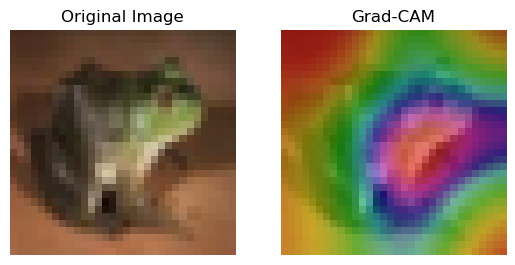

In [15]:
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(1, 2, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 2, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM')
ax.set_axis_off()

### Performing Visual Explanation

Now you have successfully built a powerful tool (i.e., Grad-CAM) that can assist you to visualize and understand the CNN models. Try to make full use of `generate_cam` and design at least **TWO** experiments that can further explain how CNN sees and understands the images. For example, apply Grad-CAM on different layers and compare their differences. Please quantitatively show some evidence (e.g., plotting some examplar images clearly and elegantly) with necessary code snippets, write down your observations and briefly explain each. 

/Users/kaibaco/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:135: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


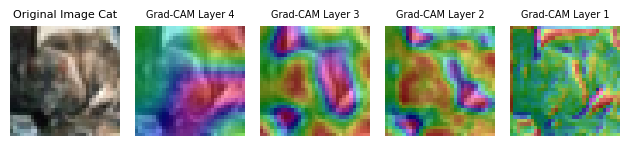

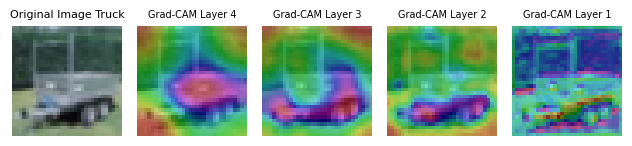

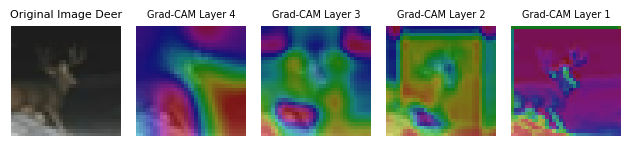

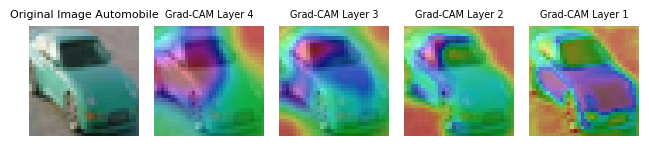

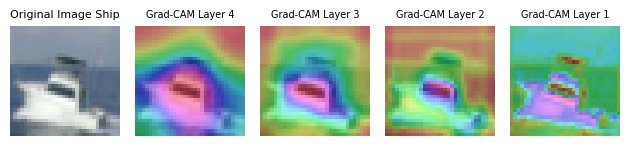

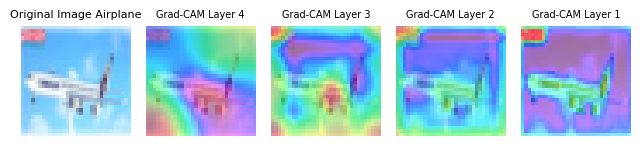

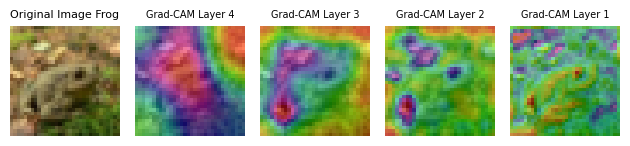

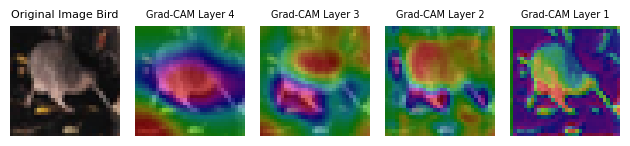

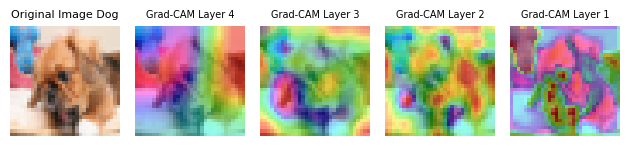

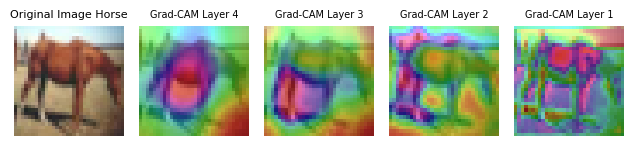

In [16]:
##############################################################################
# TODO: Write code snippets to present your experiments (hint: if you want   #
# to plot multiple images in one single figure, plt.subplot should help).    #
##############################################################################
checked_classes = []
for i in range(10):
    idx = randint(0, test_size-1)
    im, label = test_set[idx]
    while label in checked_classes:
        idx = randint(0, test_size-1)
        im, label = test_set[idx]
        
    checked_classes.append(label)
    org_im = inverse_transform(im)

    im = im.to(device)
    im = im.view(1,3,32,32)

    ax = plt.subplot(1, 5, 1)
    ax.imshow(org_im)
    ax.set_title('Original Image ' + CIFAR_CLASSES[label], fontsize = 8)
    ax.set_axis_off()

    cam4 = generate_cam(model, im, target_layer='conv4', target_class=label)
    cam3 = generate_cam(model, im, target_layer='conv3', target_class=label)
    cam2 = generate_cam(model, im, target_layer='conv2', target_class=label)
    cam1 = generate_cam(model, im, target_layer='conv1', target_class=label)

    heatmap, heatmap_on_image_4 = apply_colormap_on_image(org_im, cam4, 'hsv')
    heatmap, heatmap_on_image_3 = apply_colormap_on_image(org_im, cam3, 'hsv')
    heatmap, heatmap_on_image_2 = apply_colormap_on_image(org_im, cam2, 'hsv')
    heatmap, heatmap_on_image_1 = apply_colormap_on_image(org_im, cam1, 'hsv')

    plt.tight_layout()
    ax = plt.subplot(1, 5, 2)
    ax.imshow(heatmap_on_image_4)
    ax.set_title('Grad-CAM Layer 4', fontsize = 7)
    ax.set_axis_off()
    ax = plt.subplot(1, 5, 3)
    ax.imshow(heatmap_on_image_3)
    ax.set_title('Grad-CAM Layer 3',fontsize = 7)
    ax.set_axis_off()
    ax = plt.subplot(1, 5, 4)
    ax.imshow(heatmap_on_image_2)
    ax.set_title('Grad-CAM Layer 2',fontsize = 7)
    ax.set_axis_off()
    ax = plt.subplot(1, 5, 5)
    ax.imshow(heatmap_on_image_1)
    ax.set_title('Grad-CAM Layer 1',fontsize = 7)
    ax.set_axis_off()
    plt.show()
# your code

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

---

## Task 3: Adversarial Attack

After going through some testing results in Task 1, you might think the model performs pretty well, predicting the correct classes with high confidence, and rarely making mistakes. However, the network is not as strong as you think. The network can be vulnerable and easily fooled by simply adding some very small distributions on input images. In this section, we are going to attack our previously trained model by generating adversarial images that visually look alike but crush the model without striking a blowing.

### Adversarial Examples

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These examples are usually generated by adding imperceptible non-random perturbations to the image, which are indistinguishable to human eye, but can cause the network to fail to identify the contents of the image. There are many kinds of such attack strategies, here we focus on the Fast Gradient Sign Method (FGSM)[2]. FGSM is a white box attack where the attacker has complete access to the model being attacked. The method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. Below shows a famous exmaple taken from the paper [2], where the classification of image showing "panda" is changed to "gibbon" after adding an imperceptibly small vector: $\text{sign}(\nabla_xJ(\theta, x, y))$.

Kurakin et al.[3] propose an iterative FGSM (I-FGSM) attack by repeating FGSM for $n$ steps. I-FSGM usually results in higher classification error than FGSM. Read the papers below [2, 3], and  implement the I-FGSM within `ifgsm_attack`.

[2] [Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.](https://arxiv.org/abs/1412.6572) \
[3] [Kurakin, Alexey, Ian Goodfellow, and Samy Bengio. "Adversarial machine learning at scale." ICLR 2017.](https://arxiv.org/pdf/1611.01236)

### Attacking CNN

In [70]:
def ifgsm_attack(model, images, labels, targets=None, eps=0.07, steps=10):
    """
    Iterative Fast Gradient Sign Method (I-FGSM), https://arxiv.org/pdf/1611.01236
  
    Arguments:
        - model (nn.Module): model to attack.
        - images (torch.Tensor): input images, shape (N, C, H, W).
        - labels (torch.Tensor): ground truth labels of input images, shape (N,).
        - targets (torch.Tensor): the target classes you want the model to misclassify, shape (N,).
        - eps (float): maximum perturbation. 
        - steps (int): number of iterations.

    Output: The adversarial examples of input images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image iteratively for n steps.        #
    ##############################################################################
    adv_images_lst = []
    if type(labels) is int:
        model.eval()
        adversarial_img = images.clone().detach()
        for i in range(steps):
            adversarial_img.requires_grad = True
            output = model(adversarial_img)
            #print(output)
            one_hot_labels = torch.zeros((1, output.size()[-1]), dtype=torch.float)
            one_hot_labels[0][labels] = 1
            #print(one_hot_labels)
            loss = F.cross_entropy(output, one_hot_labels)
            model.zero_grad()
            loss.backward()
            sign_gradients = adversarial_img.grad.data.sign()
            adversarial_img = adversarial_img + eps*sign_gradients
            adversarial_img = torch.clamp(adversarial_img, 0, 1)
            adversarial_img = adversarial_img.clone().detach()
            adversarial_img = torch.max(torch.min(adversarial_img, images+eps), images-eps)
            adv_images_lst.append(adversarial_img)
        adv_images = torch.cat(adv_images_lst, dim=0)
    else:
        for im, label in zip(images, labels.tolist()):
            model.eval()
            adversarial_img = im.clone().detach()
            for i in range(steps):
                adversarial_img.requires_grad = True
                output = model(adversarial_img)
                one_hot_labels = torch.zeros((1, output.size()[-1]), dtype=torch.float)
                one_hot_labels[0][label] = 1
                loss = F.cross_entropy(output, one_hot_labels)
                model.zero_grad()
                loss.backward()
                sign_gradients = adversarial_img.grad.data.sign()
                adversarial_img = adversarial_img + eps*sign_gradients
                adversarial_img = torch.clamp(adversarial_img, 0, 1)
                adversarial_img = adversarial_img.clone().detach()
                adversarial_img = torch.max(torch.min(adversarial_img, im+eps), im-eps)
                adv_images_lst.append(adversarial_img)
                #print(adversarial_img.shape)
        adv_images = torch.stack(adv_images_lst, dim=0)
        #print(adv_images.shape)
    #print(adv_images.detach().shape)
    # your code

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    return adv_images.detach()

Pick up some images from test set, and see if the attack is successful.

Before attack:


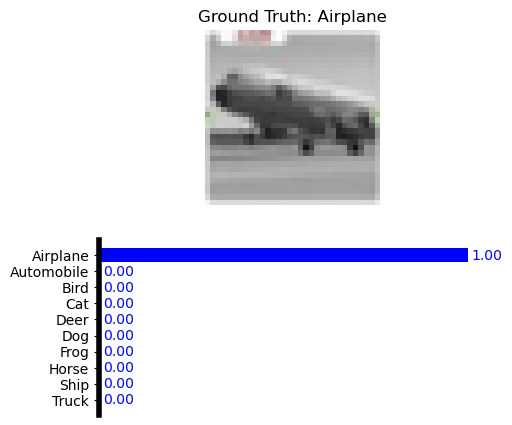

After attack:


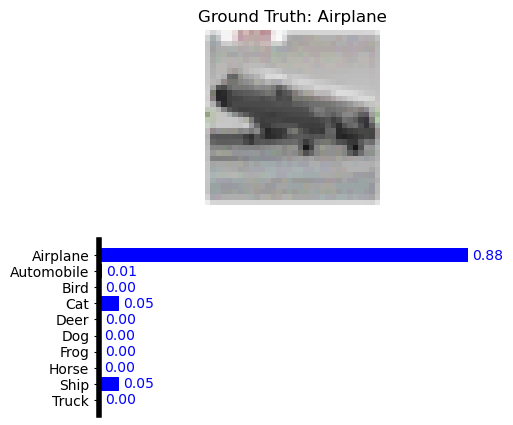

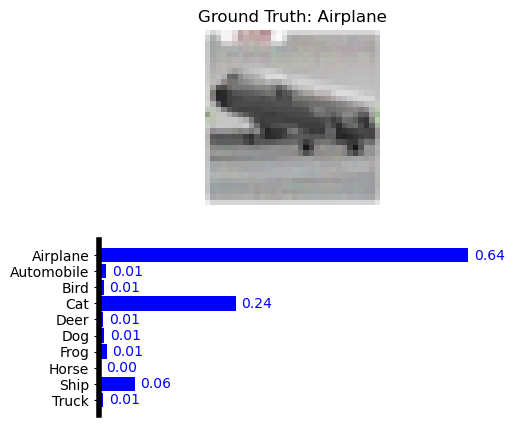

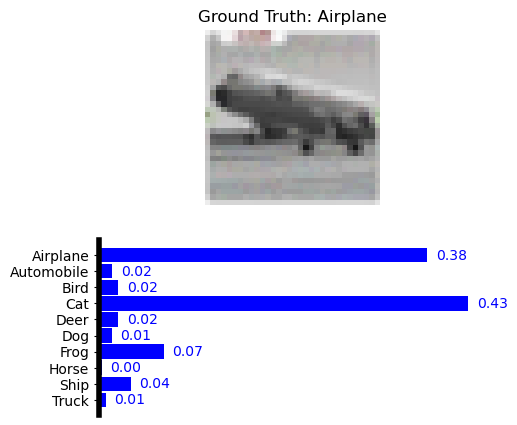

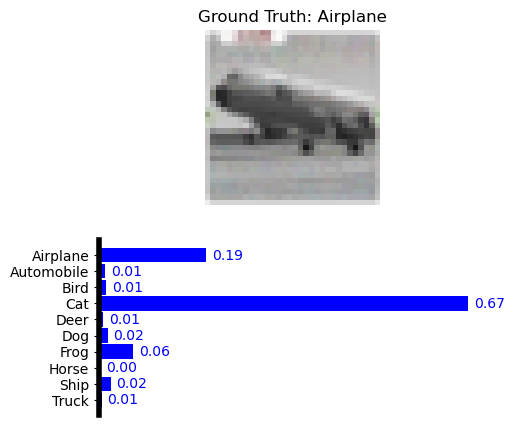

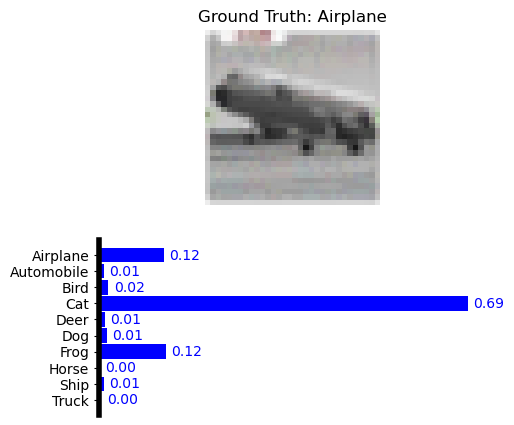

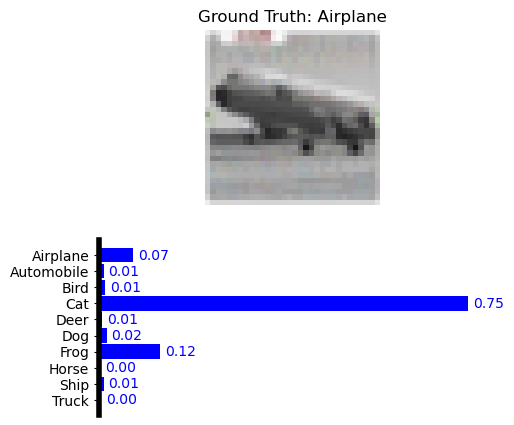

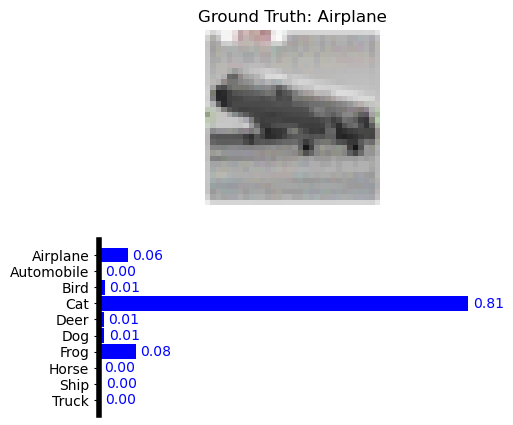

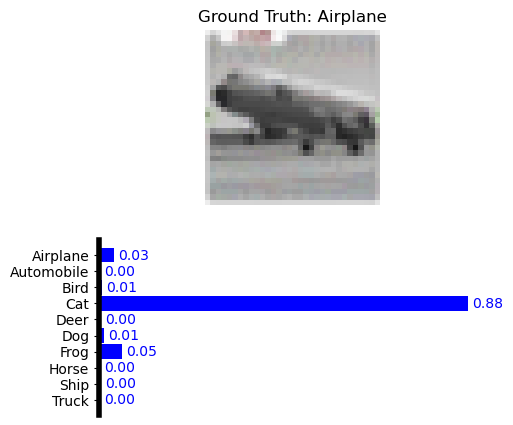

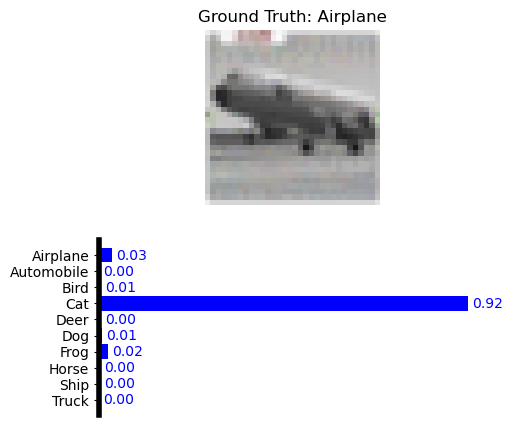

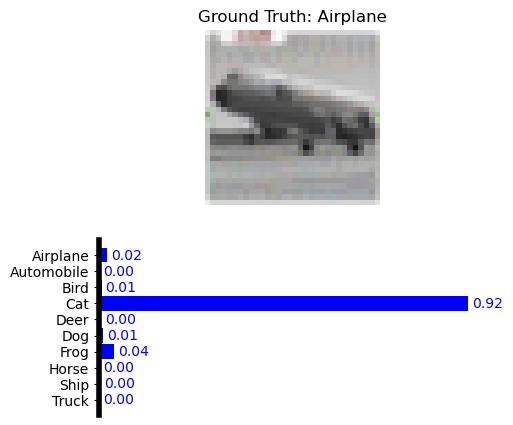

In [77]:
idx = randint(0, len(test_set)-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

print('Before attack:')
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

adv_im = ifgsm_attack(model, im, label)

print('After attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
for i in range(10):
    show_prob_cifar(inverse_transform(adv_im[i]), label, probs[i])

Run evaluation on the testing set to see how the model performs on the generated adversarial examples, and compare with results before attacks. Try different parameters (e.g., `targets`, `eps`), describe your observations with a brief explanation in the below cell. 

In [50]:
##############################################################################
# TODO: Evaluate error rate on adversarial images generated from testing set #
# with different parameter settings.                                         #
##############################################################################

# your code
def test_attack(model, test_loader, eps_val, steps):
    model.eval()
    running_error_before = 0
    running_error = 0
    for data in test_loader:
        im, label = data
        im.requires_grad=True
        output = model(im)
        _, prediction = torch.max(output, 1)
        error_before = (prediction != label).sum().item()
        #print("Error Before attack:", error_before)
        running_error_before += error_before
        adv_im = ifgsm_attack(model, im, label, eps=eps_val, steps=steps)
        scores = model(adv_im) 
        #print(scores.shape)
        #print(label.shape)
        _, prediction = torch.max(scores, 1)
        error = (prediction != label).sum().item()
        #print("Error After attack:", error)
        running_error += error
    total_error = running_error_before / test_size
    total_error_attacked = running_error / test_size
    
    print('Before attack : error rate on test set = {:.2f}%'.format(total_error * 100))
    print('After attack : error rate on test set = {:.2f}%'.format(total_error_attacked * 100))
    

#assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
test_attack(model, test_loader, 0.07, 1)
test_attack(model, test_loader, 0.035, 1)
test_attack(model, test_loader, 0.007, 1)
test_attack(model, test_loader, 0.0007, 1)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Before attack : error rate on test set = 25.87%
After attack : error rate on test set = 66.46%
Before attack : error rate on test set = 25.87%
After attack : error rate on test set = 61.35%
Before attack : error rate on test set = 25.87%
After attack : error rate on test set = 55.92%
Before attack : error rate on test set = 25.87%
After attack : error rate on test set = 54.79%


---

**Write your observations and analysis in this Markdown cell:**

---